In [ ]:
import os
from pathlib import Path


# Navigate to the project root directory (where .git is)
def find_git_root(path="."):
    path = Path(path).resolve()
    for parent in [path] + list(path.parents):
        if (parent / ".git").exists():
            return parent
    return path  # fallback if .git not found


project_root = find_git_root()
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: /Users/sherman/GitHub/ISYE-6740/Final Project/Workspace


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option("display.max_columns", 50)

In [ ]:
data = pd.read_parquet("data/processed/features.parquet")
display(data.head())
print(f"Data shape: {data.shape}")

,avg_days_between_purchases,avg_discount_rate,avg_product_price,avg_spend_per_transaction,avg_vitality_days,customer_city,customer_country,days_since_first_purchase,days_since_last_purchase,distance_from_nyc_km,first_purchase_date,last_purchase_date,max_spend_single_transaction,min_spend_single_transaction,most_frequent_category_id,num_transactions,num_unique_categories,num_unique_products,proportion_allergic_items,proportion_discounted_transactions,proportion_high_class,proportion_low_class,proportion_medium_class,proportion_unknown_class,purchase_period_days,total_discount_value,total_quantity,total_spend
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.987172,0.026154,51.924478,50.208627,23.292308,Oklahoma,United States,126.774309,3.569667,2131.269080,2018-01-03 05:24:59.690,2018-05-06 10:19:40.780,96.5200,0.37350,11,65,11,61,0.353846,0.153846,0.400000,0.353846,0.246154,0.0,123.0,111.53037,65,3263.56073
2,1.992316,0.028125,54.189208,53.092065,27.000000,Pittsburgh,United States,128.606963,5.083388,506.691978,2018-01-01 09:25:58.360,2018-05-04 21:59:55.310,96.3871,2.66592,1,64,11,59,0.406250,0.187500,0.265625,0.375000,0.359375,0.0,123.0,70.21711,64,3397.89219
3,1.852645,0.023944,47.909541,46.870292,25.788732,Houston,United States,128.727704,0.895195,2281.344820,2018-01-01 06:32:06.410,2018-05-09 02:30:55.190,95.7865,3.33240,5,71,11,61,0.380282,0.154930,0.309859,0.281690,0.408451,0.0,127.0,73.78668,71,3327.79072
4,1.844941,0.024638,46.893168,45.254503,21.202899,Cleveland,United States,126.974314,1.518331,649.856161,2018-01-03 00:36:59.240,2018-05-08 11:33:36.170,99.3193,0.37350,2,69,11,68,0.304348,0.159420,0.434783,0.260870,0.304348,0.0,125.0,113.06787,69,3122.56073
5,2.191776,0.032203,46.989202,44.921107,28.016949,Buffalo,United States,127.660775,0.537779,470.567204,2018-01-02 08:08:29.000,2018-05-09 11:05:35.920,99.8755,0.68460,3,59,11,55,0.237288,0.237288,0.271186,0.372881,0.355932,0.0,127.0,122.01759,59,2650.34531


Data shape: (98759, 28)


In [ ]:
# Drop columns that won't help in PCA
df = data.drop(
    columns=[
        "customer_city",
        "customer_country",
        "first_purchase_date",
        "last_purchase_date",
        "most_frequent_category_id",
        "proportion_unknown_class",
    ]
)

In [ ]:
# Standardizing features before PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

In [ ]:
# Correlation matrix
scaled_df = pd.DataFrame(scaled_features, columns=df.columns)
corr_matrix = scaled_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop those feature selected
feature_selected = scaled_df.drop(columns=to_drop)

feature_selected.shape

(98759, 16)

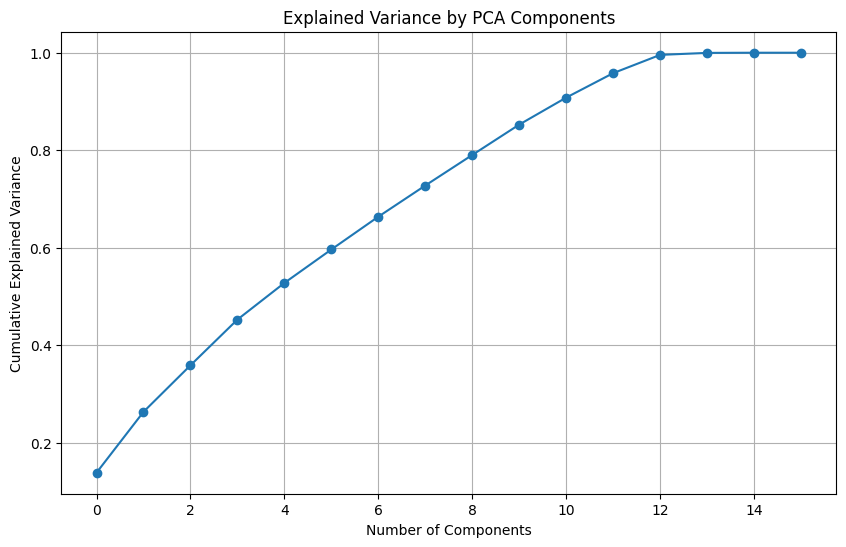

In [ ]:
# Fit PCA
pca = PCA()
pca.fit(feature_selected)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [ ]:
# Find number of components to explain ~95% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

Number of components to retain 95% variance: 12


In [ ]:
# Apply PCA with optimal components
pca = PCA(n_components=n_components)
pca_transformed = pca.fit_transform(feature_selected)

# Convert to DataFrame for inspection
pca_df = pd.DataFrame(
    pca_transformed,
    columns=[f"PC{i+1}" for i in range(n_components)],
)

pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-2.086791,0.836101,2.291868,-1.113426,0.093491,-0.295621,-0.138608,0.561424,-0.266261,0.362602,-0.193434,-0.252108
1,-2.180598,0.687199,-0.024305,0.920541,0.687031,-0.803198,0.289762,1.632453,-1.773967,0.426245,-0.350312,0.466343
2,-2.343263,-1.514740,-1.239261,-0.676459,-0.027992,-0.494244,0.345700,-0.009370,-0.055598,0.245809,0.190836,-0.529740
3,-2.250979,-0.297470,0.926379,-2.608623,-0.683863,0.223716,-0.565596,-0.715189,-0.760900,-0.689213,0.113852,-0.940316
4,-2.383124,-1.316329,-0.012394,0.772601,-0.032799,1.509569,-0.730088,-1.021283,-0.671970,-0.816922,-1.407872,0.590901



Evaluating k = 2...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 3...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 4...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 5...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 6...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 7...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 8...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 9...
  GaussianMixture clustering...
  Evaluating GaussianMixture...

Evaluating k = 10...
  GaussianMixture clustering...
  Evaluating GaussianMixture...


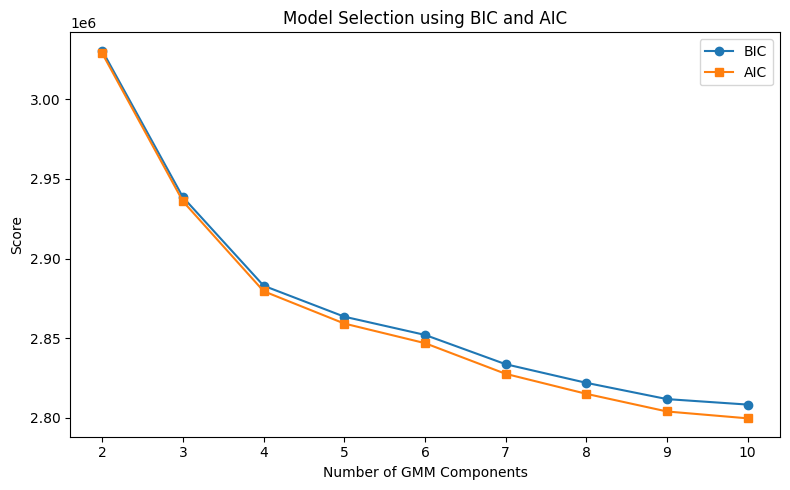

,k,Silhouette,Calinski Harabasz,Davies Bouldin
0,2,0.312051,6943.936301,1.437910
1,3,0.069807,6496.856730,3.041547
2,4,0.060039,6896.215796,2.786267
3,5,0.029033,5971.833315,3.908948
4,6,0.033169,5205.826626,3.427813
5,7,0.019101,4431.788823,4.529139
6,8,0.018734,4323.164393,3.790063
7,9,0.013845,3745.843529,3.712359
8,10,0.010635,3465.795853,4.048993


In [ ]:
# Set a reproducible random state
RANDOM_STATE = 42
rng = np.random.default_rng(seed=RANDOM_STATE)

# Subsample size for silhouette scoring
subsample_size = 10_000
X_pca = pca_df.copy()

# Subsample for silhouette score
sample_idx = rng.choice(
    X_pca.shape[0],
    size=min(subsample_size, X_pca.shape[0]),
    replace=False,
)

X_pca_sample = X_pca.iloc[sample_idx]

# Range of cluster numbers to test
n_components_range = range(2, 11)
results = []

# Store BIC and AIC scores
bic_scores = []
aic_scores = []

# Fit GMM with different numbers of components
for k in n_components_range:
    print(f"\nEvaluating k = {k}...")
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=RANDOM_STATE,
    )

    print("  GaussianMixture clustering...")
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

    gmm_labels = gmm.predict(X_pca)
    gmm_labels_sample = gmm.predict(X_pca_sample)

    print("  Evaluating GaussianMixture...")
    k_sil = silhouette_score(X_pca_sample, gmm_labels[sample_idx])
    k_ch = calinski_harabasz_score(X_pca, gmm_labels)
    k_db = davies_bouldin_score(X_pca, gmm_labels)

    results.append(
        {
            "k": k,
            "Silhouette": k_sil,
            "Calinski Harabasz": k_ch,
            "Davies Bouldin": k_db,
        }
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)


# Plot BIC and AIC to choose optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, bic_scores, marker="o", label="BIC")
plt.plot(n_components_range, aic_scores, marker="s", label="AIC")
plt.xlabel("Number of GMM Components")
plt.ylabel("Score")
plt.title("Model Selection using BIC and AIC")
plt.legend()
plt.tight_layout()
plt.show()

display(results_df)

In [ ]:
# Fit GMM with 4 clusters
gmm_clusters = GaussianMixture(
    n_components=4,
    covariance_type="full",
    random_state=RANDOM_STATE,
)

gmm_labels = gmm_clusters.fit_predict(X_pca)

# Add GMM 4-cluster labels to the original DataFrame
labelled_df = df.copy()
labelled_df["cluster_label"] = gmm_labels

In [ ]:
# Summarize Clusters
def summarize_clusters(df, label_col="cluster_label"):
    summary = df.groupby(label_col).mean(numeric_only=True)
    size = df[label_col].value_counts().sort_index().rename("count")
    return pd.concat([size, summary], axis=1)


# Visualize with Pairplot
def visualize_clusters(df, label_col="cluster_label", features=None):
    if features is None:
        features = [
            "avg_spend_per_transaction",
            "avg_discount_rate",
            "total_spend",
            "avg_days_between_purchases",
            "num_transactions",
        ]

    # Ensure selected features + label exist
    features = [f for f in features if f in df.columns]
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found in DataFrame.")

    selected_cols = features + [label_col]
    clean_df = df[selected_cols].copy()

    # Convert all to numeric and drop invalid rows
    for col in selected_cols:
        clean_df[col] = pd.to_numeric(clean_df[col], errors="coerce")

    clean_df = clean_df.dropna().astype("float64")

    # Plot
    sns.pairplot(clean_df, hue=label_col, palette="Set2", corner=True, diag_kind="hist")
    plt.suptitle(f"Cluster Visualization ({label_col})", y=1.02)
    plt.show()

,count,avg_days_between_purchases,avg_discount_rate,avg_product_price,avg_spend_per_transaction,avg_vitality_days,days_since_first_purchase,days_since_last_purchase,distance_from_nyc_km,max_spend_single_transaction,min_spend_single_transaction,num_transactions,num_unique_categories,num_unique_products,proportion_allergic_items,proportion_discounted_transactions,proportion_high_class,proportion_low_class,proportion_medium_class,purchase_period_days,total_discount_value,total_quantity,total_spend
cluster_label,,,,,,,,,,,,,,,,,,,,,,,
0,3798,2.060861,0.029946,50.584084,638.043510,25.778113,126.935463,2.140256,2044.841130,1263.884737,20.963146,63.225908,9.988152,58.678515,0.345806,0.199816,0.315236,0.337578,0.347185,124.294365,1245.936532,823.149552,40353.875712
1,22463,1.905687,0.029932,51.020816,680.459805,26.111325,125.334689,3.643297,2083.060197,1339.435194,24.978215,66.523483,11.000000,61.841339,0.347805,0.199558,0.316125,0.339029,0.344846,121.182656,1398.619839,917.764769,45372.022087
2,47197,1.885249,0.029909,50.458267,511.177666,25.970768,127.509723,1.485303,2080.020626,1019.474509,4.948281,69.482552,11.000000,64.471344,0.346570,0.199548,0.315493,0.337787,0.346719,125.525266,1085.387625,727.845732,35544.899745
3,25301,1.913703,0.030126,51.376381,848.213670,26.121853,127.902497,1.110465,2098.107769,1659.296720,41.775595,68.942255,11.000000,63.925339,0.348358,0.201099,0.318668,0.339350,0.341982,126.295957,1835.390512,1177.364571,58589.670791


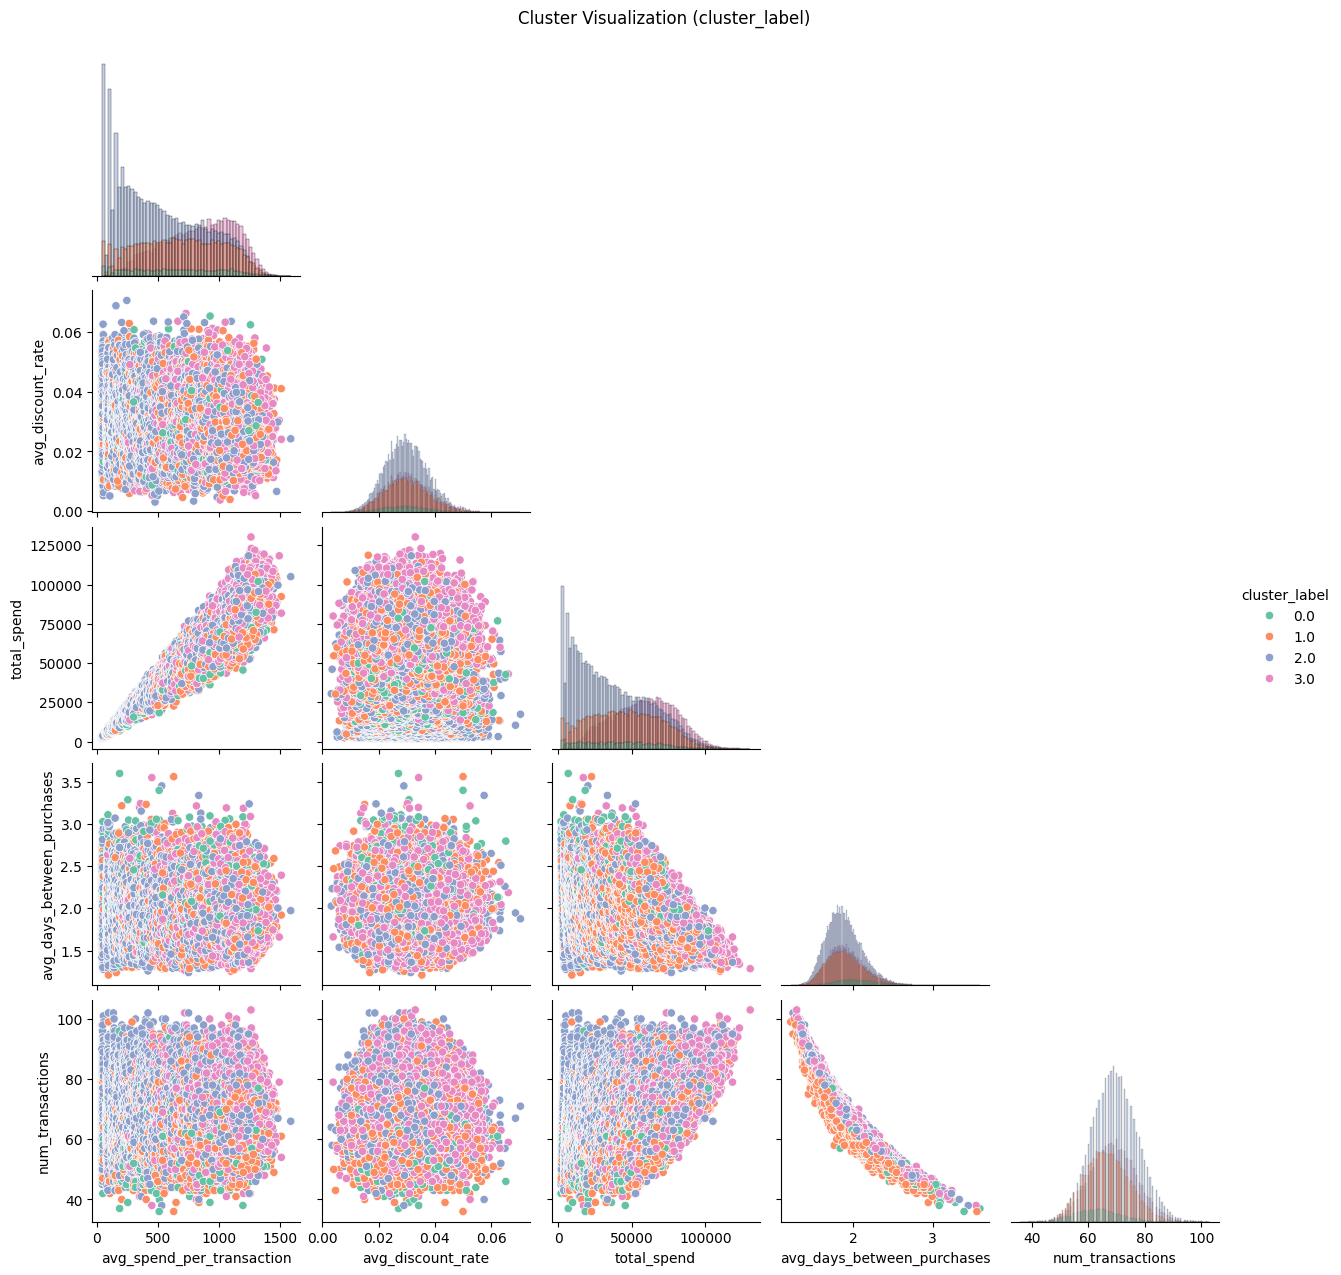

In [ ]:
cluster_summary = summarize_clusters(labelled_df, label_col="cluster_label")
display(cluster_summary)

visualize_clusters(labelled_df, label_col="cluster_label")

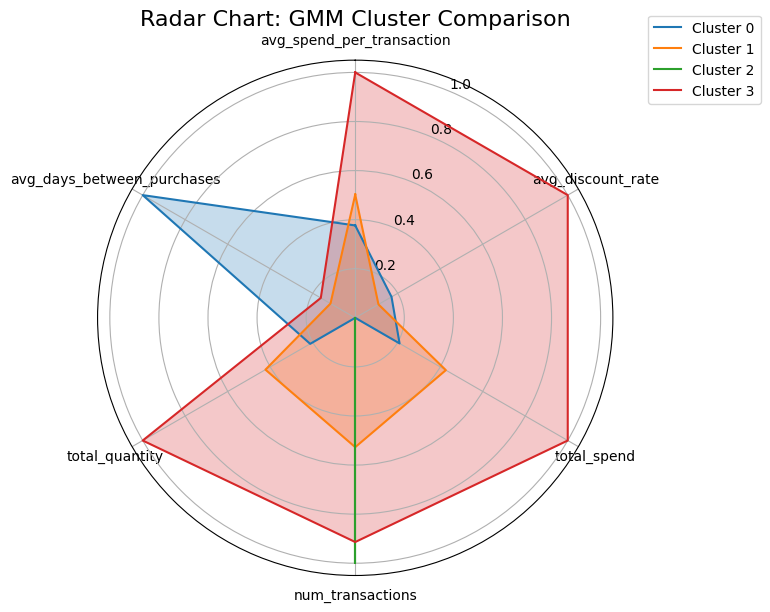

In [ ]:
# Select metrics to compare
features = [
    "avg_spend_per_transaction",
    "avg_discount_rate",
    "total_spend",
    "num_transactions",
    "total_quantity",
    "avg_days_between_purchases",
]

# Normalize the data for radar chart (MinMax scaling 0-1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(cluster_summary[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df["cluster_label"] = cluster_summary.reset_index()["cluster_label"].astype(str)

# Setup angles for radar axes
labels = features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in scaled_df.iterrows():
    values = row[features].tolist()
    values += values[:1]  # repeat first value to close the loop
    ax.plot(angles, values, label=f"Cluster {row['cluster_label']}")
    ax.fill(angles, values, alpha=0.25)

# Configure chart aesthetics
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar Chart: GMM Cluster Comparison", size=16)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

### **Cluster Summary Insights**

| Cluster                                          | Key Traits                                                                                                                                                                                                                                                                          |
| ------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Cluster 0** (Low spenders, moderate frequency) | - Smallest group (3,757 users)<br>- **Lowest total spend** and moderate **avg spend per transaction**<br>- Higher **days between purchases** and **days since last purchase**, suggesting lower recency<br>- Lowest transaction volume and quantity<br>- More distant from NYC      |
| **Cluster 1** (High engagement, moderate spend)  | - **Largest group** (36,636 users)<br>- Moderate avg spend, high number of transactions, **lowest days since last purchase** (high recency)<br>- Higher product diversity and category coverage<br>- Good mix across class proportions<br>- **Closest to NYC**                      |
| **Cluster 2** (Low spenders, frequent)           | - Moderate size<br>- **Lowest avg spend per transaction**, very low min transaction<br>- High transaction frequency but **low total spend** and **quantity**<br>- Furthest distance from NYC (likely non-local/remote users)<br>- Possibly price-sensitive shoppers                 |
| **Cluster 3** (High spenders, high value)        | - ~28K users<br>- **Highest avg spend per transaction** and **max single transaction**<br>- **Highest total spend and quantity**<br>- Moderate frequency, high product diversity<br>- Good recency but slightly less than Cluster 1<br>- Slightly skewed toward high-class products |

---

### **Visual Distribution Observations**

From the pairplot:

- **avg_spend_per_transaction vs total_spend** shows a strong positive relationship across clusters, especially for Cluster 3.
- **num_transactions vs avg_days_between_purchases** shows a negative trend, i.e., more transactions are associated with more frequent purchases (as expected).
- **Cluster 3** is visibly distinct in avg spend and total spend axes — they occupy the top-right region.
- **Cluster 2** is concentrated at the **lower-left**, indicating low-value and frequent purchases.
- **Cluster 1** forms the dense middle range, suggesting mainstream behavior.
- **Cluster 0** is sparse and spread, more isolated — likely disengaged or dormant users.

---

### **Interpretation and Business Takeaways**

| Cluster       | Strategy Recommendation                                                                 |
| ------------- | --------------------------------------------------------------------------------------- |
| **Cluster 0** | Re-engagement strategies: promotions, loyalty incentives. Potential churn risk.         |
| **Cluster 1** | Core user base. Maintain engagement through consistent service, personalized campaigns. |
| **Cluster 2** | Price-sensitive segment. Emphasize value packs, discounts, and free shipping.           |
| **Cluster 3** | Premium segment. Upsell high-end items, exclusive offerings, early access to launches.  |


In [ ]:
cluster_label = labelled_df[["cluster_label"]].reset_index()
cluster_label.to_parquet("data/processed/clustered_customer_gmm.parquet", index=False)